# **Regressão Logística**

Conforme falamos na última aula, a regressão logística é um modelo linear que pode utilizar as características de entrada ($X$) e estimar a *probabilidade* daquele conjunto de características pertecer a cada uma das classes.

Vamos lembrar da equação que define a regressão logística:

$$p(Y=1|X) = \frac{e^{a_0+\sum_{i=1}^{m}a_ix_i}}{1+e^{a_0+\sum_{i=1}^{m}a_ix_i}}$$

Na equação acima:

- $a_0$ - é conhecido como *intercepto* e representa o valor da probabilidade daquele conjunto de características pertencer à classe 1, quando todos os outros valores $x_i = 0$. Pode ou não ter significado físico.
- $x_i$ são os valores das características que queremos modelar.
- $a_i$ são as *inclinações* ou *coeficientes angulares*. Representam o efeito médio que cada variável $x_i$ tem sobre a probabilidade. Voltaremos a eles posteriormente.

O termo $a_0 + \sum_{i=1}^{m} a_i x_i$ determina a reta ou o hiperplano que vai separar as classes.

Nativamente, a regressão logística funciona para classificação de problemas binários (0 / 1). Porém, com algumas modificações (que falaremos lá em redes neurais), ela pode ser adaptada para problemas multi-classes.

Vamos começar a resolver nosso problema de crédito bancário (Fonte: https://www.kaggle.com/datasets/mpwolke/cusersmarildownloadsgermancsv)

In [43]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
# para normalizacao - MinMaxScaler
# para padronizacao normal - StandardScaler
# para padronizacao robusta - RobustScaler
from sklearn.preprocessing import RobustScaler
# para projetos com muitos modelos é preciso agrupar cada modelo com o Scaler
# para nao ficar bagunçado, exemplo do problema com mais de 100 modelos treinados
from sklearn.pipeline import Pipeline

#ignorar os warnings (opcional)
warnings.filterwarnings('ignore')

In [3]:
# conectar o colab ao drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/ALGORITMOS DE IA/DATASET/german.csv', sep=';')
data.head()

,Creditability,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,...,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [5]:
#analisar tipagem dos dados - dados nullos forma 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account_Balance                    1000 non-null   int64
 2   Duration_of_Credit_monthly         1000 non-null   int64
 3   Payment_Status_of_Previous_Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit_Amount                      1000 non-null   int64
 6   Value_Savings_Stocks               1000 non-null   int64
 7   Length_of_current_employment       1000 non-null   int64
 8   Instalment_per_cent                1000 non-null   int64
 9   Sex_Marital_Status                 1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration_in_Current_address        1000 non-null   int64
 12  Most_valuable_availab

In [6]:
# analisar dados nullos - forma 2
data.isna().sum()

,0
Creditability,0
Account_Balance,0
Duration_of_Credit_monthly,0
Payment_Status_of_Previous_Credit,0
Purpose,0
Credit_Amount,0
Value_Savings_Stocks,0
Length_of_current_employment,0
Instalment_per_cent,0
Sex_Marital_Status,0


<Axes: >

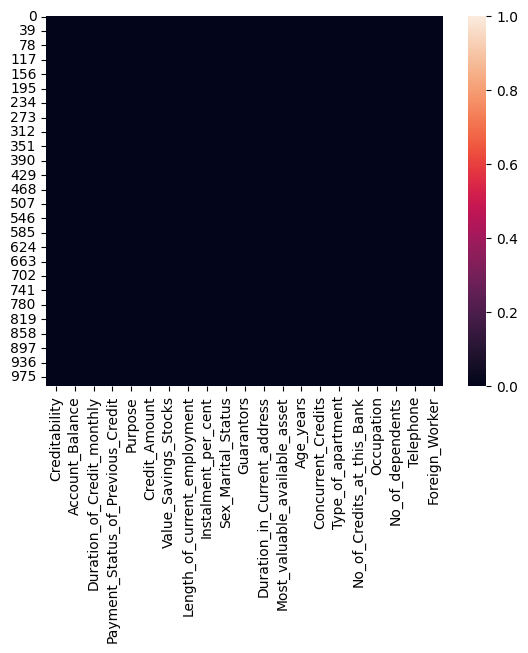

In [7]:
# analise de dados nullos - forma 3
sns.heatmap(data.isna(), vmin=0, vmax=1)

In [8]:
# adicionar coluna nula
data['test'] = np.nan

<Axes: >

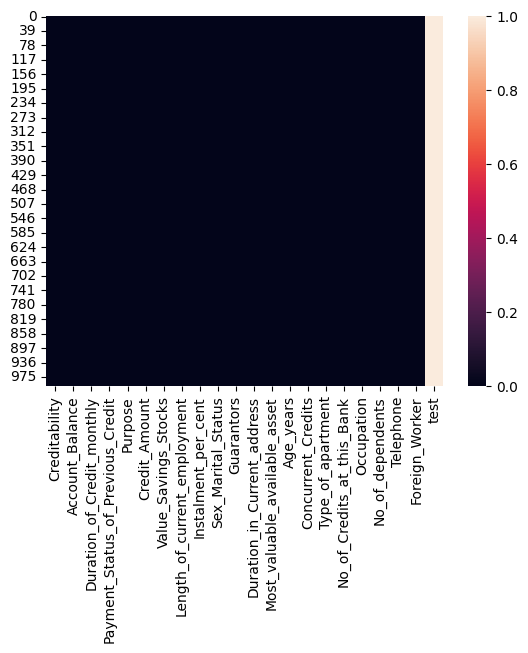

In [9]:
# analise de dados nullos - forma 3
sns.heatmap(data.isna(), vmin=0, vmax=1)

In [10]:
# eliminando a coluna teste
data.drop(columns=['test'], inplace=True)
#data = data.drop(columns=['test'])

In [11]:
# (opcional) modificar os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ','_').str.replace('()','').str.replace(')','')

In [12]:
# verificar o balanceamento das classes
proportions = data['creditability'].value_counts(normalize=True)

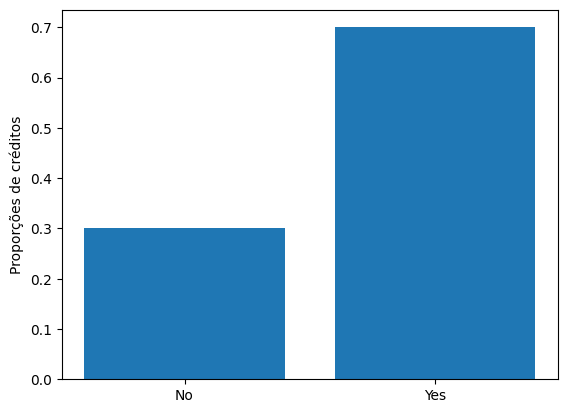

In [13]:
# outra forma de ver o balanceamento de classes
plt.bar(x=proportions.index, height=proportions.values)
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.ylabel('Proporções de créditos')
plt.show()

In [14]:
data = data[['creditability', 'credit_amount', 'age_years', 'duration_of_credit_monthly',
             'concurrent_credits', 'length_of_current_employment', 'no_of_dependents']]
data.head()

,creditability,credit_amount,age_years,duration_of_credit_monthly,concurrent_credits,length_of_current_employment,no_of_dependents
0,1,1049,21,18,3,2,1
1,1,2799,36,9,3,3,2
2,1,841,23,12,3,4,1
3,1,2122,39,12,3,3,2
4,1,2171,38,12,1,3,1


In [15]:
# verificação info dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   creditability                 1000 non-null   int64
 1   credit_amount                 1000 non-null   int64
 2   age_years                     1000 non-null   int64
 3   duration_of_credit_monthly    1000 non-null   int64
 4   concurrent_credits            1000 non-null   int64
 5   length_of_current_employment  1000 non-null   int64
 6   no_of_dependents              1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [16]:
# outra forma de verificar o tamanho dos dados
data.shape

(1000, 7)

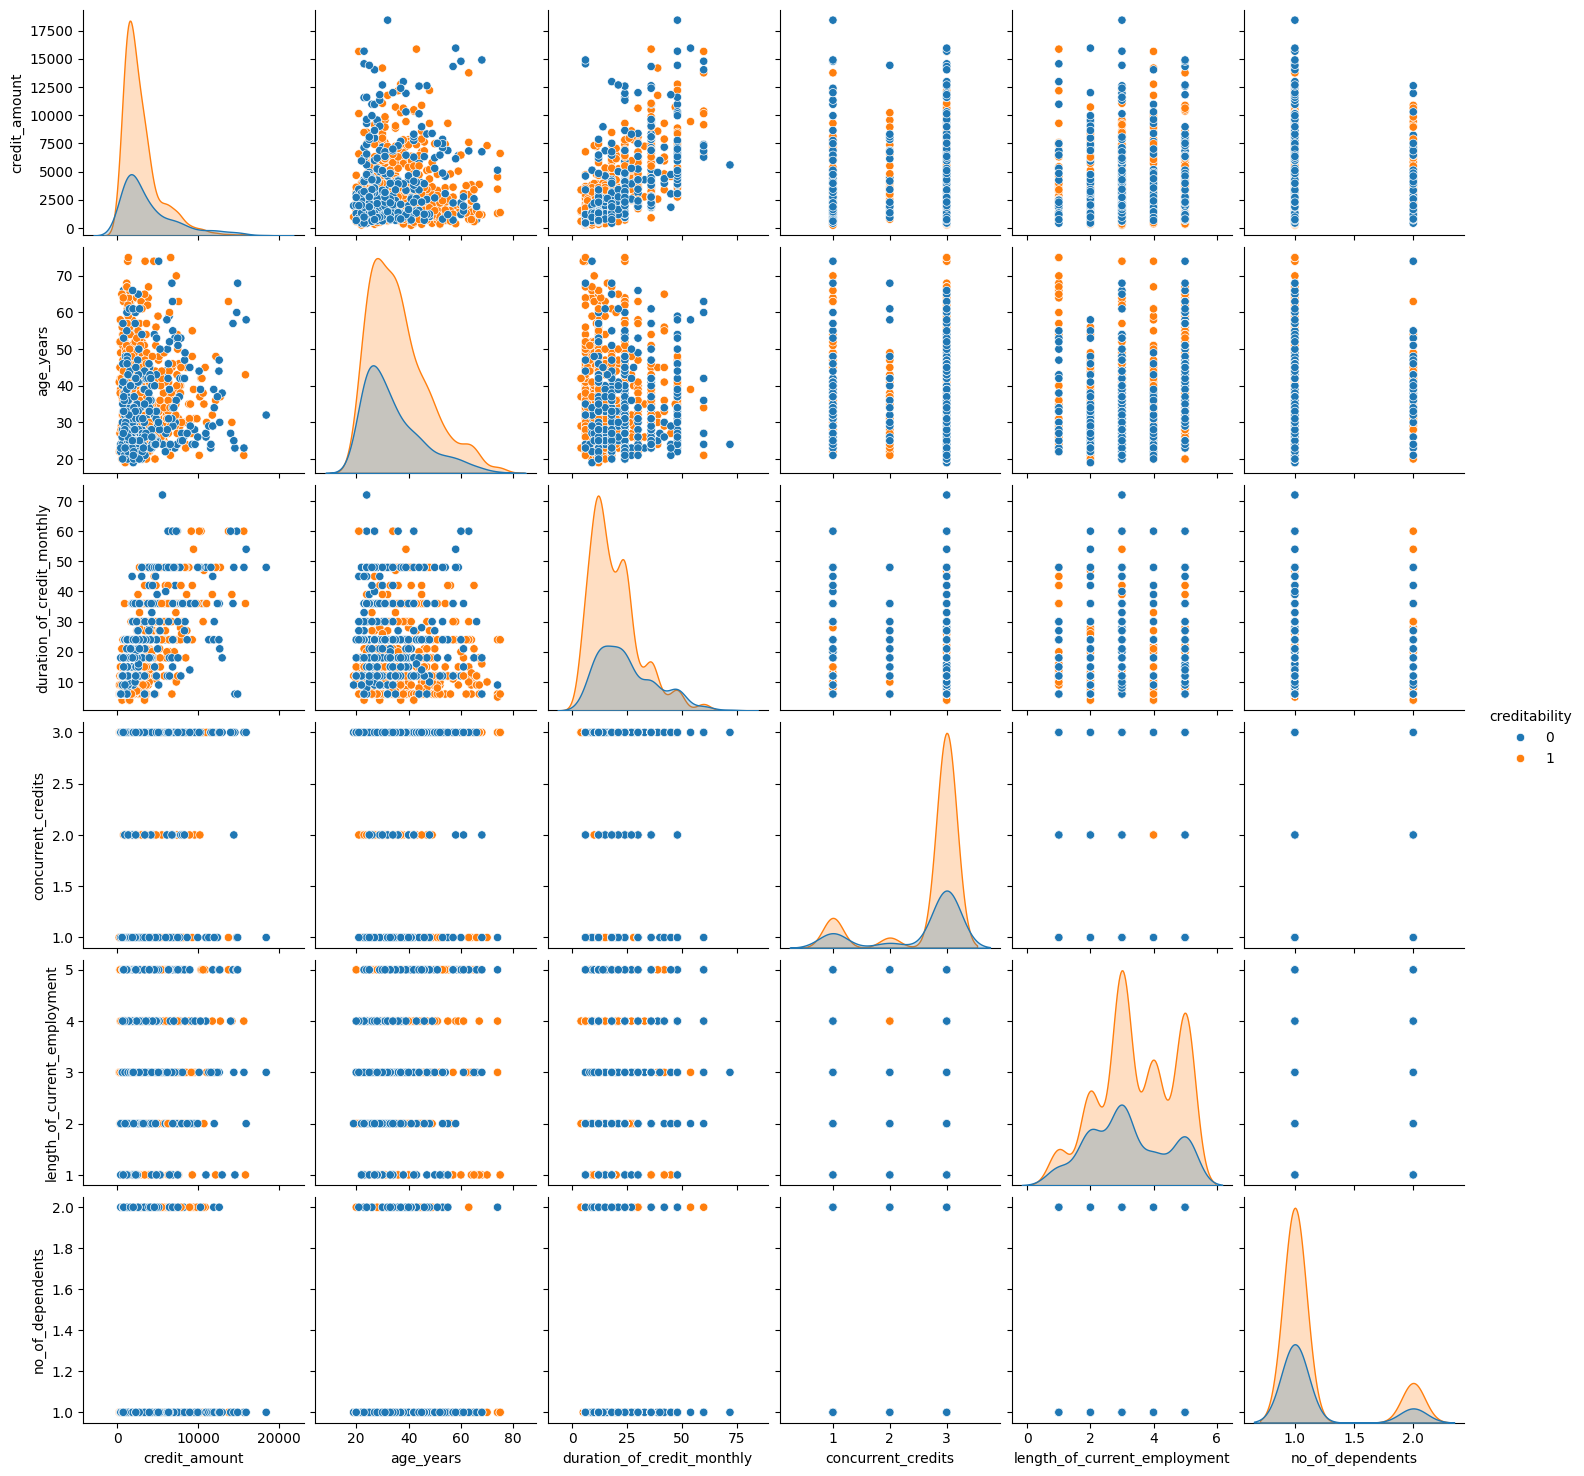

In [17]:
# analise de separabilidade linear (visual)
sns.pairplot(data, hue='creditability')

In [18]:
# separando x e y
x = data.drop(columns=['creditability'])
y = data[['creditability']]

In [19]:
#separacao treino e teste (stratify mantem as proporcoes originais)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [20]:
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.7,0.7,0.7
1,0.3,0.3,0.3


In [21]:
# criar um modelo baseline - hipotese: todos merecem credito (todos = 1)
y_base = np.repeat(1, repeats=y_test.shape[0])
y_base

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
# metricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.70      1.00      0.82       210

    accuracy                           0.70       300
   macro avg       0.35      0.50      0.41       300
weighted avg       0.49      0.70      0.58       300



In [23]:
# criar um primeiro modelo de regressão logistica
rl1 = LogisticRegression(penalty=None).fit(x_train, y_train)

#fazendo previsao do teste
yhat_rl1 = rl1.predict(x_test)

#analisando metricas
print(classification_report(y_test, yhat_rl1))

              precision    recall  f1-score   support

           0       0.59      0.22      0.32        90
           1       0.74      0.93      0.82       210

    accuracy                           0.72       300
   macro avg       0.66      0.58      0.57       300
weighted avg       0.69      0.72      0.67       300



In [24]:
#prevendo probabilidades
yhat_rl1_prob = rl1.predict_proba(x_test)
yhat_rl1_prob

array([[0.3748367 , 0.6251633 ],
       [0.11837618, 0.88162382],
       [0.23286329, 0.76713671],
       [0.2046838 , 0.7953162 ],
       [0.25576462, 0.74423538],
       [0.13197786, 0.86802214],
       [0.52917496, 0.47082504],
       [0.13127823, 0.86872177],
       [0.36417228, 0.63582772],
       [0.21732565, 0.78267435],
       [0.13999546, 0.86000454],
       [0.20039854, 0.79960146],
       [0.44965558, 0.55034442],
       [0.45835356, 0.54164644],
       [0.34279245, 0.65720755],
       [0.10475795, 0.89524205],
       [0.2162507 , 0.7837493 ],
       [0.25773116, 0.74226884],
       [0.12369392, 0.87630608],
       [0.28037241, 0.71962759],
       [0.14612906, 0.85387094],
       [0.13203753, 0.86796247],
       [0.24409748, 0.75590252],
       [0.57188853, 0.42811147],
       [0.18800971, 0.81199029],
       [0.10685801, 0.89314199],
       [0.33335116, 0.66664884],
       [0.29616131, 0.70383869],
       [0.34020795, 0.65979205],
       [0.23977302, 0.76022698],
       [0.

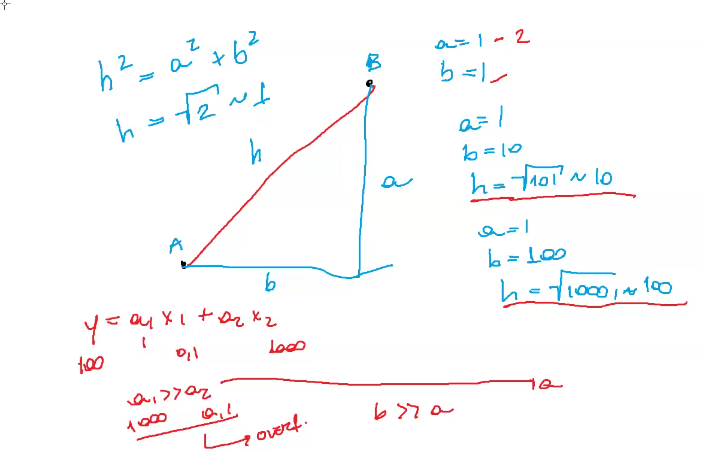

In [26]:
# normalizacao (nao é boa no caso de um dado muito discrepante por ex, 0, 100, 5000)
# padronizacao
# padronizacao robusta (é a melhor para a distribuicao das variaveis, prof. sempre usa)

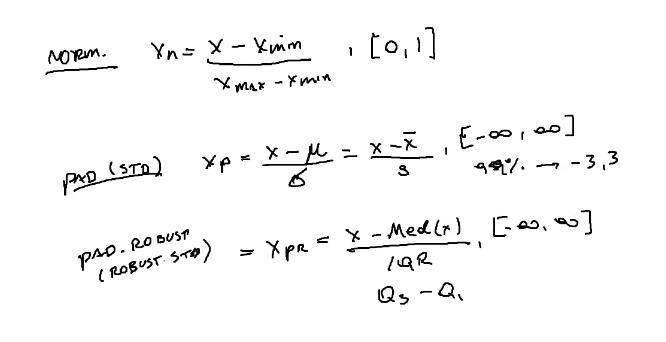

In [27]:
# analisando as grandezas
x_train.head()

,credit_amount,age_years,duration_of_credit_monthly,concurrent_credits,length_of_current_employment,no_of_dependents
399,6078,32,12,3,4,1
678,2728,35,15,1,4,1
800,1381,35,24,3,3,1
943,12389,37,36,1,3,1
45,1216,23,18,3,2,1


In [29]:
# ver o que acontece no scaler
# normalizar os dados sempre depois que separou os dados do treino e teste
RobustScaler().fit_transform(x_train)

array([[ 1.44281077, -0.06666667, -0.5       ,  0.        ,  0.5       ,
         0.        ],
       [ 0.16345236,  0.13333333, -0.25      , -2.        ,  0.5       ,
         0.        ],
       [-0.35096429,  0.13333333,  0.5       ,  0.        ,  0.        ,
         0.        ],
       ...,
       [ 0.08478136,  0.4       ,  1.        ,  0.        ,  1.        ,
         1.        ],
       [ 3.31258354, -0.46666667,  1.5       ,  0.        , -1.        ,
         0.        ],
       [-0.3692954 ,  0.66666667,  0.5       ,  0.        , -1.        ,
         1.        ]])

In [31]:
# criar um pipeline de modelagem
rl2 = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty=None))
])

# ajustando o pipeline
rl2.fit(x_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model', LogisticRegression(penalty=None))])

In [34]:
# acessar "coisas" do pipeline
print('Mediana e IQR de cada coluna')
print(rl2['scaler'].center_)
print(rl2['scaler'].scale_)

# acessar os coeficientes do modelo
print()
print('Coeficientes do Modelo')
print('Modelo RL1', rl1.coef_)
print('Modelo RL2', rl2['model'].coef_)

Mediana e IQR de cada coluna
[2.3e+03 3.3e+01 1.8e+01 3.0e+00 3.0e+00 1.0e+00]
[2.6185e+03 1.5000e+01 1.2000e+01 1.0000e+00 2.0000e+00 1.0000e+00]

Coeficientes do Modelo
Modelo RL1 [[ 1.11177666e-05  1.00982346e-02 -4.63046515e-02  3.01004828e-01
   2.54439794e-01 -1.27386887e-01]]
Modelo RL2 [[ 0.02896409  0.16257095 -0.55123916  0.31832712  0.51693913 -0.09522172]]


In [35]:
# fazer novas previsoes
yhat_rl2 = rl2.predict(x_test)

# analisar as metricas
print(classification_report(y_test, yhat_rl2))

              precision    recall  f1-score   support

           0       0.57      0.22      0.32        90
           1       0.74      0.93      0.82       210

    accuracy                           0.72       300
   macro avg       0.65      0.58      0.57       300
weighted avg       0.69      0.72      0.67       300



Também podemos incorporar conhecimentos específicos do negócio para avaliar nossos modelos. Vamos supor as seguintes situações:

- **Cliente credível previsto como credível (TP)**: + 50.00
- **Cliente credível previsto como não credível (FN)**: -5.00
- **Cliente não credível previsto como não credível (TN)**: - 5.00
- **Cliente não credível previsto como credível (FP)**: - 150.00

In [41]:
def profit(yreal, ypred):
  # calcular a matriz de confuscao
  cm = confusion_matrix(yreal, ypred)

  # extrair pontuações
  tp = cm[1, 1] # verdadeiros positivos
  fp = cm[0, 1] # falsos positivos
  tn = cm[0, 0] # verdadeiros negativos
  fn = cm[1, 0] # falsos negativos

  # lucro total
  lucro = (50 * tp) + (-5 * fn) + (-5 * tn) + (-150 * fp)

  # retornar o lucro medio por cliente
  return lucro / yreal.shape[0]

In [42]:
print('Lucro medio - modelo baseline ', profit(y_test, y_base))
print('Lucro medio - modelo RL1 ', profit(y_test, yhat_rl1))
print('Lucro medio - modelo RL2 ', profit(y_test, yhat_rl2))

Lucro medio - modelo baseline  -10.0
Lucro medio - modelo RL1  -2.9
Lucro medio - modelo RL2  -3.0833333333333335


Finalmente, supondo que escolhemos o último modelo como nosso modelo final, podemos usá-lo para explicar decisões de negócio para pessoas não técnicas. Façamos uma análise de importância de atributos.

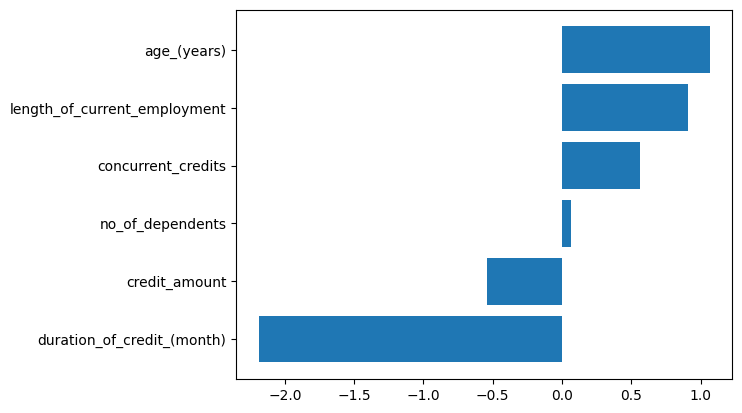

In [ ]:
# criando conjunto de dados de importâncias de atributos
imp = pd.DataFrame(x_train.columns, columns=['atributos'])
imp['importancia'] = pipe_rl['rl2'].coef_[0]
imp.sort_values(by=['importancia'], inplace=True)

# construindo gráfico
plt.barh(y=imp['atributos'], width=imp['importancia'])
plt.show()